## Web Scraping Indeed Job Posting for Data Aspect

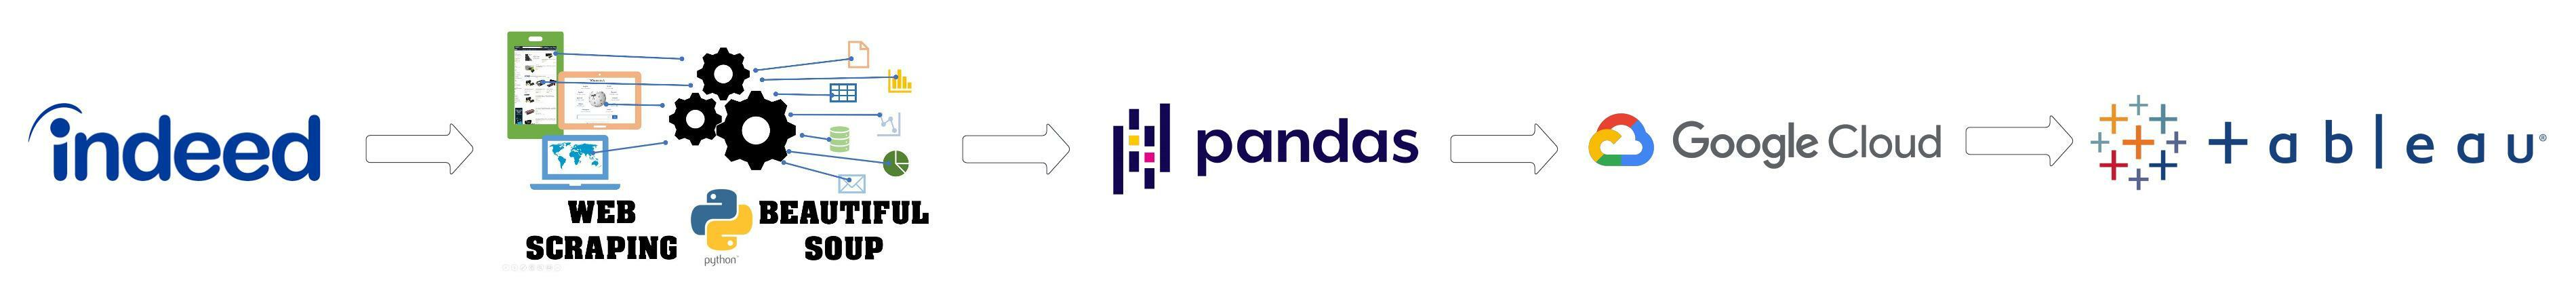

### Process:

+ Send a request to a URL using the get method of requests module, and convert the data into HTML code

+ Pulling data out of HTML and XML files using BS4
+ Find and extract key pieces of information from each posting
+ Transform the result into Pandas Dataframe
+ Load data to google drive
+ Visualize the result using Tableau public: ***https://public.tableau.com/app/profile/zhunqiang/viz/IndeedPostingAnalysisforDADSDE/IndeedPostingAnalysisforDADSDE***

#### 1. Import required modules.

In [1]:
import pandas as pd
import requests # Request allows user to send HTTP/1.1 requests.
from bs4 import BeautifulSoup   # Beautiful Soup(bs4) is a Python library for pulling data out of HTML and XML files
import time
import re
import seaborn as sns
from matplotlib import pyplot as plt

# PyDrive is a wrapper library of google-api-python-client that simplifies many common Google Drive API tasks
from pydrive.auth import GoogleAuth  
from pydrive.drive import GoogleDrive

#### 2. Scraping a sample page

In [2]:
job_title = 'Data%20Analyst'
city = 'Toronto'
radius = '25'
page_number=20

In [3]:
url = 'https://ca.indeed.com/jobs?q='+job_title+'&l='+city+\
      '%2C%20ON'+'&radius='+radius+'&start='+str(page_number)
#conducting a request of the stated URL above:
page = requests.get(url)
# Specifying a desired format of 'page' using the html parser
# This allows python to read the various components of the page, rather than treating it as one long string.
text = page.text
print('url: ',url)

url:  https://ca.indeed.com/jobs?q=Data%20Analyst&l=Toronto%2C%20ON&radius=25&start=20


In [4]:
soup = BeautifulSoup(text, 'html.parser')

In [5]:
# Find and extract key pieces of information from each job posting
for posting in soup.findAll(attrs={'data-jk' : re.compile('\D')}):
    print('Title:',posting.find(name='span', attrs={'title':re.compile('\D')}).get_text(),
          '|',
          'CompanyName: ',posting.find(name='span', attrs={'class':'companyName'}).get_text())
    

Title: Data Analyst | CompanyName:  BGIS
Title: In-line Inspection Data Analyst | CompanyName:  Novitech Inc.
Title: Data Analyst - Sportsbook | CompanyName:  theScore Inc.
Title: Business Analyst | CompanyName:  Soroc Technology Inc.
Title: Sr Data Analyst, Sports | CompanyName:  Rogers Communications
Title: BUSINESS ANALYST | CompanyName:  City of Toronto
Title: Data Analyst | CompanyName:  MSi Corp (Bell Canada)
Title: Analyst | CompanyName:  CIBC
Title: Customer Supply Chain Analyst, LTC | CompanyName:  Cardinal Health
Title: Junior Business Analyst (remote) | CompanyName:  Software International
Title: Jr. Data/Reporting Analyst | CompanyName:  Scarsin
Title: Data Analyst | CompanyName:  Toronto School of Management
Title: Business Data Analyst | CompanyName:  Arrow Workforce Solutions
Title: Data Analyst (Summer Student 2022) | CompanyName:  GWL Realty Advisors
Title: Junior Business Analyst | CompanyName:  RPM TECHNOLOGIES CORP


#### 3. The Scraping Loop

In [6]:
max_results_per_city_per_title = 150
city = 'Toronto'
title_set = ['Data%20Scientist','Data%20Analyst','Data%20Engineer']
radius = '50'
columns = ['title', 'company', 'location', 'salary', 'rating', 'posting_url','jobDescriptionText']
df = pd.DataFrame(columns = columns)

In [ ]:
start_timer = time.time()

for job_title in title_set:
    for page_number in range(130, max_results_per_city_per_title, 10):

        url = 'https://ca.indeed.com/jobs?q='+job_title+'&l='+city+\
              '%2C%20ON'+'&radius='+radius+'&start='+str(page_number)
        #conducting a request of the stated URL above:
        page = requests.get(url)
        # Specifying a desired format of 'page' using the html parser
        # This allows python to read the various components of the page, rather than treating it as one long string.
        text = page.text
        soup = BeautifulSoup(text, 'html.parser')
        time.sleep(15)
        
        # Find and extract key pieces of information from each job posting
        for posting in soup.findAll(attrs={'data-jk' : re.compile('\D')}):
            time.sleep(5)
            #specifying row num for index of job posting in dataframe
            num = (len(df) + 1)
            # 1.Find and extract Job Title from current job posting
            try:
                title = posting.find(name='span', attrs={'title':re.compile('\D')}).get_text()
            except:
                title = 'N/A'
            # 2.Find and extract Company name from current job posting
            try:
                company = posting.find(name='span', attrs={'class':'companyName'}).get_text()
            except:
                company = 'N/A'
            # 3.Find and extract Location from current job posting
            try:
                location = posting.find(name='div', attrs={'class':'companyLocation'}).get_text()
            except:
                location = 'N/A'
            # 4.Find and extract Salary from current job posting, note some of the posting does not post the salary info
            try:
                salary = posting.find(name='div', attrs={'class':re.compile('\D\Salary\D')}).get_text()
            except:
                salary = 'N/A'
            # 5.Find and extract Rating from current job posting, note some of the posting does not include Rating info
            try:
                rating = float(posting.find(name='span', attrs={'class':'ratingNumber'}).get_text())
            except:
                rating = 0
            # 6.Find and extract PostingID from current job posting
            data_jk = posting.attrs['data-jk']
            # 7.Extract PostingURL from current job posting
            posting_url = 'https://ca.indeed.com/viewjob?jk=' + data_jk
            # 8.Withdrawing detail descriptions of the current job posting from the PostingURL
            time.sleep(2)
            try:
                posting_page = requests.get(posting_url)
                posting_text = posting_page.text
                posting_soup = BeautifulSoup(posting_text, 'html.parser')
                jobDescription = posting_soup.find_all(name='div', attrs={'id':'jobDescriptionText'})
                jobDescriptionText = jobDescription[0].get_text()
                #create the list of job post info
                job_post = [title, company, location, salary, rating, posting_url,jobDescriptionText]
                #appending list of job post info to dataframe at index num
                df.loc[num] = job_post
            except:
                pass
            
        print('Title: ',job_title,'| City: ',city,'| Page: ', round(page_number/10)+1, '| Running: ', round((time.time()-start_timer)/60,2), 'mins')
        time.sleep(85)            

end_timer = time.time()
print('Running: ', round((end_timer-start_timer)/60,2), 'mins')

Title:  Data%20Scientist | City:  Toronto | Page:  11 | Running:  2.1 mins


#### 4. Data Engineering, cleaning and create new features

In [ ]:
print('size of DataFrame before drop duplicates: ',df.shape)
df = df.drop_duplicates(subset='posting_url')
print('size of DataFrame after drop duplicates: ',df.shape)

In [19]:
print('size of DataFrame before drop duplicates: ',df.shape)
df = df.drop_duplicates(subset='posting_url')
print('size of DataFrame after drop duplicates: ',df.shape)

size of DataFrame before drop duplicates:  (169, 43)
size of DataFrame after drop duplicates:  (126, 43)


In [75]:
df['senior'] = df.title.str.contains('Sr.|Senior',case=False, regex=True)
df['junior'] = df.title.str.contains('Jr.|Junior',case=False, regex=True)
df['remote'] = df.location.str.contains('remote',case=False, regex=True)
df['Data Analyst'] = df.title.str.contains(r'Analyst',case=False, regex=True)
df['Data Scientist'] = df.title.str.contains(r'Scientist',case=False, regex=True)
df['Data Engineer'] = df.title.str.contains(r'Engineer',case=False, regex=True)

In [76]:
skills = [
#     Top programming languages for DA/DS/DE
    'SQL','Python','SAS','Java','JavaScript','Scala','Julia',' R ',
    # Top Data Visualization / BI Tools for DA/DS/DE
     'Tableau','PowerBI','MicroStrategy','Plotly','QlikView',
     # Top Databases for DA/DS/DE
     'Snowflake','Teradata','MongoDB','Cassandra','DynamoDB',
     # Top Big Data tools for DA/DS/DE
     'PySpark','Hadoop',
     # Top Cloud tools for DA/DS/DE
     'AWS','Azure','Google Cloud',
     # Top Deep Learning tools for DS
     'TensorFlow','Pytorch',
     # Other tools for DA/DS/DE
     'apache','JIRA','Excel','Machine Learning']
for skill in skills:
    df[skill] = df.jobDescriptionText.str.contains(skill,case=False, regex=True)
    

In [77]:
for column in ['title', 'company', 'location', 'salary', 'posting_url','jobDescriptionText']:
    df[column] = df[column].str.replace(',',' ')

In [78]:
df.jobDescriptionText = df.jobDescriptionText.str.replace('\n','')

In [79]:
df['contract'] = df.jobDescriptionText.str.contains('Fixed term contract',case=False, regex=True)


In [85]:
df = df[~df.salary.str.contains('month')]

In [86]:
s = df.salary.fillna('0').str.replace('a year','').str.replace(' ','').str.replace('anhour','').\
        str.replace('$','').str.split('-')
s = [int(float(l[0])*0.35+float(l[-1])*0.65) for l in s]
df['salary_avg'] = s
df['salary'] = [re.sub(r' \d\d\d', r'k', s) if pd.isna(s)==False else s for s in df.salary]

C:\Users\zhunq\AppData\Local\Temp/ipykernel_71520/4077719658.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  s = df.salary.fillna('0').str.replace('a year','').str.replace(' ','').str.replace('anhour','').\


ValueError: could not convert string to float: 'N/A'

#### 5. Analysis key skills required for the job posted

In [ ]:
rank_skills = df.loc[:,skills].sum()
rank_skills = pd.DataFrame(rank_skills.sort_values(ascending=False),columns=['count'])

In [ ]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(12,7)})
ax = sns.barplot(x='count',
                 y=rank_skills.index,     
                 data=rank_skills,
                 )

#### 6. Export the dataset to googledrive

In [81]:
#saving data frame as a local csv file
file_name = 'Indeed_Posting_to_P10.csv'
df.to_csv(file_name,index=False, encoding='utf-8')

In [ ]:
# Create connection to Google Drive using pydrive
gauth = GoogleAuth()
gauth.LocalWebserverAuth() # client_secrets.json need to be in the same directory as the script
drive = GoogleDrive(gauth)

In [ ]:
uploaded = drive.CreateFile({'title': file_name})
uploaded.SetContentFile(file_name)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))